In [1]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [1]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3,tavily_api_key="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")
#web_search_results = web_search.invoke("南京在哪")

#print(web_search_results["results"][0]["content"])

In [2]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(
    model="qwen3-235b-a22b-thinking-2507",
    api_key="sk-081025394d9e4f35adbb67ea07c3dae1",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

In [2]:
print(llm.invoke('你好'))

content='你好！😊 有什么我可以帮助你的吗？' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 9, 'total_tokens': 180, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-235b-a22b-thinking-2507', 'system_fingerprint': None, 'id': 'chatcmpl-826da4d4-a010-92cf-8cc7-ffbd8776f929', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--591fdabb-e81b-464b-9d9c-906cdd20ed4c-0' usage_metadata={'input_tokens': 9, 'output_tokens': 171, 'total_tokens': 180, 'input_token_details': {}, 'output_token_details': {}}


In [3]:
research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        "你是一个研究代理。\n\n指令：\n- 仅协助与研究相关的任务，不得进行任何数学计算\n- 完成任务后，直接向主管回复\n- 仅回复你的工作结果，不得包含任何其他文字。"
    ),
    name="research_agent",
)

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [7]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "南京在哪?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_e9640608c7b4411aaa8f3f)
 Call ID: call_e9640608c7b4411aaa8f3f
  Args:
    query: 南京在哪?


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "南京在哪?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://zh.wikivoyage.org/wiki/%E5%8D%97%E4%BA%AC", "title": "南京- 来自维基导游的旅行指南", "content": "南京市，是中国江苏省的省会。 南京是长江下游和长三角地区重要产业城市、长江三角北翼中心城市和江苏省的政治、经济、科教、文化、信息中心，也是全国综合性交通和通信枢纽", "score": 0.84277284, "raw_content": null}, {"url": "https://www.nanjing.gov.cn/zzb/njgl/csgk/201910/t20191016_1678402.html", "title": "城市概况", "content": "南京，简称宁，江苏省省会，位于江苏省西南部、长江下游，南起北纬31°14'，北抵北纬32°37'，西起东经118°22'，东迄东经119°14'，东西最大横距约70千米，南北最大纵", "score": 0.81097376, "raw_content": null}, {"url": "https://www.travelking.com.tw/tourguide/scenery

In [5]:
def add(a: float, b: float):
    """将两个数字相加。"""
    return a + b


def multiply(a: float, b: float):
    """将两个数字相乘。"""
    return a * b


def divide(a: float, b: float):
    """将两个数字相除。"""
    return a / b


math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply, divide],
    prompt=(
        "你是一个数学代理。\n\n"
        "指令：\n"
        "- 仅协助处理数学相关任务\n"
        "- 完成任务后，直接回复给主管\n"
        "- 仅回复你的工作结果，不要包含任何其他文字。"
    ),
    name="math_agent",
)

In [7]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_7b2c160333d54277899571)
 Call ID: call_7b2c160333d54277899571
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_4250de70160240e8a3245e)
 Call ID: call_4250de70160240e8a3245e
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56.0




In [6]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, math_agent],
    prompt=(
        "你是一个管理两个代理的主管：\n"
        "- 一个研究代理。将研究相关任务分配给这个代理\n"
        "- 一个数学代理。将数学相关任务分配给这个代理\n"
        "一次只分配工作给一个代理，不要并行调用代理。\n"
        "不要自己做任何工作。"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

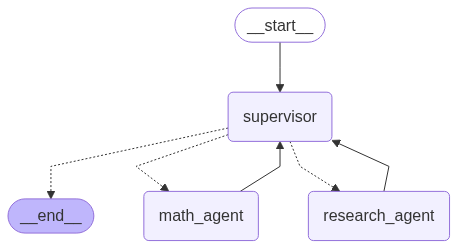

In [7]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [9]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "查找美国和纽约州2024年的GDP。纽约州占美国GDP的百分比是多少？",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

根据研究代理的调查结果：

**美国2024年GDP**  
美国2024年实际GDP同比增长**2.8%**（美国经济分析局BEA数据），基于2023年GDP约27.97万亿美元推算，2024年GDP总量约为**28.75万亿美元**。

**纽约州2024年GDP占比**  
由于纽约州2024年官方GDP数据尚未发布，研究代理通过历史占比推算：  
- 纽约州GDP长期占美国GDP约**8.17%**（基于2022年数据，纽约州GDP 2.08万亿美元 / 美国GDP 25.46万亿美元）。  
- 按此比例估算，纽约州2024年GDP约为 **2.35万亿美元**（28.75万亿美元 × 8.17%）。  

**结论**  
纽约州2024年GDP预计占美国GDP的 **8.17%**（注：最终数据需以美国经济分析局及纽约州政府后续官方统计为准）。




In [10]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    """
    创建一个“交接”工具函数，用于在 LangGraph 的 Supervisor-Worker 架构中
    把当前对话状态移交给指定名称的子 Agent。

    参数
    ----
    agent_name : str
        目标子 Agent 的名称，必须与 Supervisor 图中注册的节点名一致。
    description : str | None
        工具的描述文本。如果为 None，则使用默认描述 "Ask {agent_name} for help."。

    返回
    ----
    handoff_tool : Callable
        一个已用 @tool 装饰的函数，可直接注入到 Supervisor 的工具列表。
    """
    # 动态生成工具名，例如 agent_name="math_agent" -> "transfer_to_math_agent"
    name = f"transfer_to_{agent_name}"

    # 如果调用者没有提供描述，则使用默认描述
    description = description or f"Ask {agent_name} for help."

    # 用 LangGraph 的 @tool 装饰器注册工具
    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        """
        实际执行交接逻辑的工具函数。

        参数
        ----
        state : MessagesState
            当前对话状态，由 LangGraph 注入。
        tool_call_id : str
            本次工具调用的唯一 ID，由 LangGraph 注入。

        返回
        ----
        Command
            一个 LangGraph Command 对象，告诉框架：
            - goto=agent_name        : 跳转到哪个子 Agent
            - update                 : 更新后的状态
            - graph=Command.PARENT   : 在父图（Supervisor）作用域内执行
        """
        # 构造一条工具消息，记录交接动作
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }

        # 使用 Command 把对话状态连同新消息一起发送到目标 Agent
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    # 返回已装饰的工具函数，供 Supervisor 添加进 tools 列表
    return handoff_tool


# 创建研究代理的交接工具
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

# 创建数学代理的交接工具
assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

In [11]:
supervisor_agent = create_react_agent(
    model=llm,
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "你是一个管理两个代理的主管：\n"
        "- 一个研究代理。将研究相关任务分配给这个代理\n"
        "- 一个数学代理。将数学相关任务分配给这个代理\n"
        "一次只分配工作给一个代理，不要并行调用代理。\n"
        "不要自己做任何工作。"
    ),
    name="supervisor",
)

In [12]:
from langgraph.graph import END

# 定义多代理主管图
supervisor = (
    StateGraph(MessagesState)
    # 注意：`destinations` 仅用于可视化，不影响运行时行为
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # 总是返回到主管
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

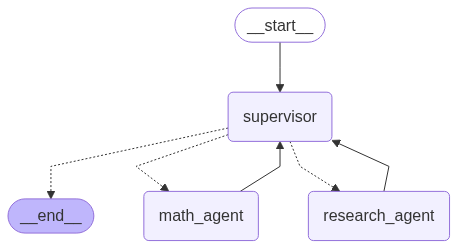

In [13]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [14]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

New York state GDP in 2024: $2.297 trillion (Wikipedia). US GDP in 2024: ~$28.5 trillion (estimated). Percentage contribution: (2.297 / 28.5) * 100 ≈ 8.1%.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message ==================================
Name: math_agent

8.06


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

New York state's GDP in 2024 was **$2.297 trillion**, while the